In [1]:
# Graph Neural Network
import torch_geometric as pyG
from torch_geometric.nn import GCNConv
from torch_geometric.data import Data
from torch_geometric.loader import DataLoader
from torch_geometric.utils import to_networkx

# Neural Networks
import torch
import torch.nn.functional as F
import torch.nn as nn


# data processing
import pandas as pd
import networkx as nx

# plotting
import matplotlib.pyplot as plt

# utils
import random
from tqdm import tqdm

In [2]:
# load bike dataset from datasets folder
bike_data = pd.read_csv('datasets/MontrealBikeLane.csv')
# removing columns that have any missing data
bike_data = bike_data.dropna(axis=1)
bike_data["Date"] = pd.to_datetime(bike_data["Date"], format="%d/%m/%Y")
bike_data = bike_data.sort_values(by=['Date', 'Time'], ascending=True)
bike_data = bike_data.reset_index(drop=True)
bike_data.head(12)

,Date,Time,Berri1,Boyer,Brébeuf,CSC (Côte Sainte-Catherine),Maisonneuve_2,Maisonneuve_3,Notre-Dame,Parc,PierDup,Rachel / Hôtel de Ville,Rachel / Papineau,René-Lévesque,Saint-Antoine,Saint-Urbain,Totem_Laurier,University,Viger
0,2015-01-01,00:00,58,12,4,17,49,21,16,16,7,58,91,24,3,17,78,21,6
1,2015-01-02,00:00,75,7,5,15,113,27,9,32,11,109,177,32,13,11,57,77,4
2,2015-01-03,00:00,79,7,3,7,107,36,12,18,2,71,131,33,5,14,174,40,5
3,2015-01-04,00:00,10,1,21,0,35,29,1,0,0,6,11,6,1,1,20,6,0
4,2015-01-05,00:00,42,0,2,0,90,21,1,1,6,0,5,49,20,0,41,56,10
5,2015-01-06,00:00,101,0,1,1,153,38,3,22,1,1,12,64,23,29,121,91,5
6,2015-01-07,00:00,121,15,5,3,144,35,1,43,0,11,24,40,3,5,120,63,4
7,2015-01-08,00:00,70,0,36,0,139,36,4,55,0,38,67,21,7,1,83,78,2
8,2015-01-09,00:00,88,3,5,0,135,26,12,46,1,26,63,14,10,1,166,79,1
9,2015-01-10,00:00,29,7,6,0,70,17,3,20,0,15,29,0,7,0,32,41,1


<Axes: xlabel='Date'>

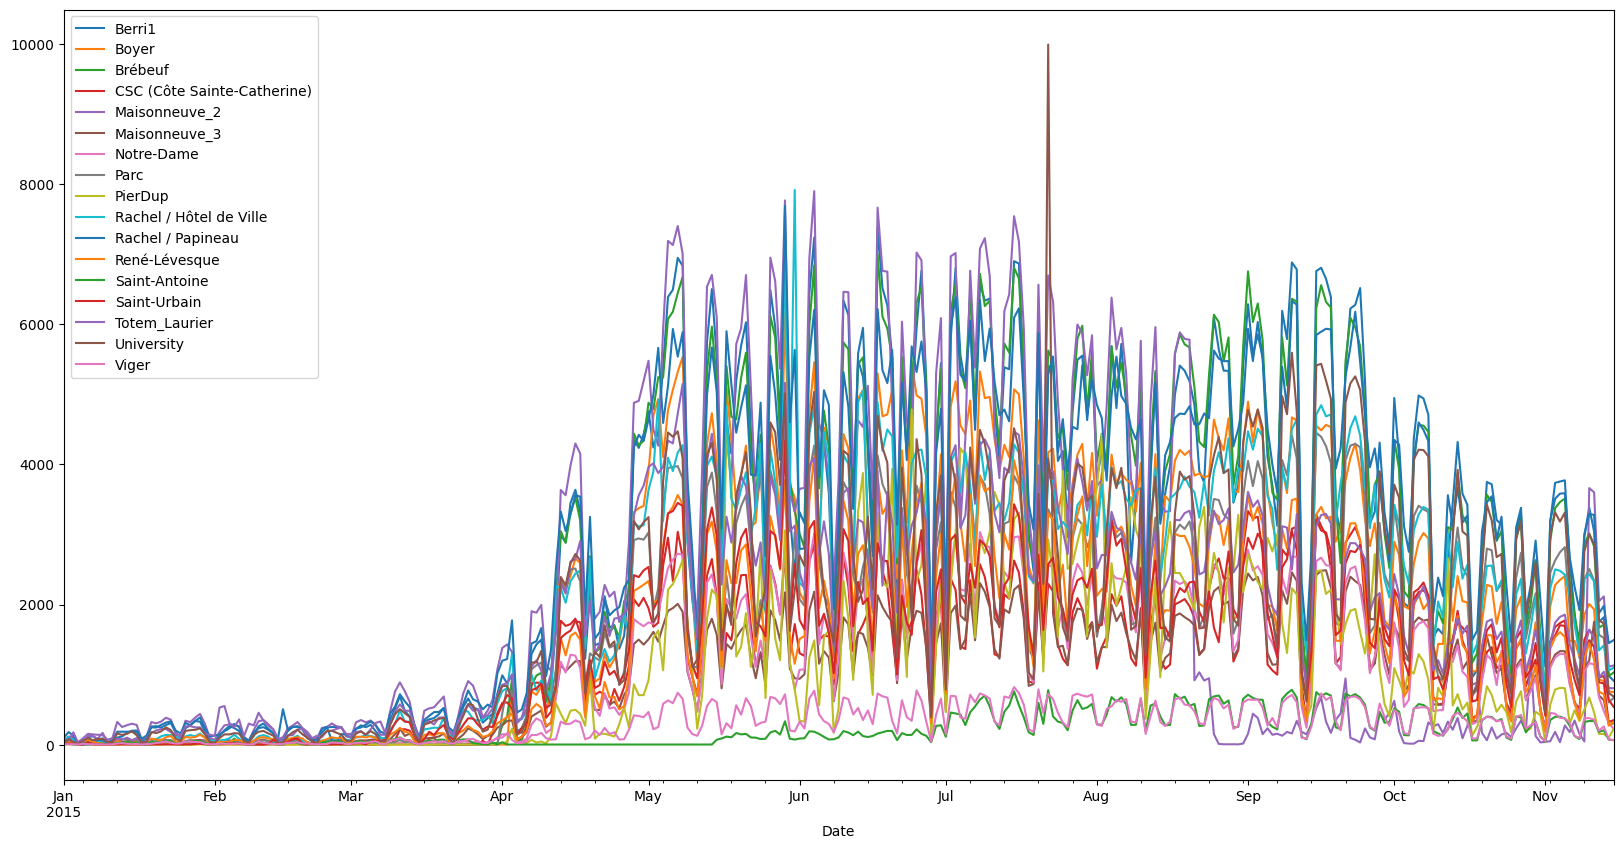

In [3]:
bike_data.loc[:, [col not in  ["Time"] for col in bike_data.columns]].plot(x="Date", figsize=(20,10))

In [4]:
# normalizing with min-max with scikit-learn
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler()
target_columns = [col for col in bike_data.columns if col not in ['Date', 'Time']]
bike_data.loc[:, target_columns] = scaler.fit_transform(bike_data.loc[:, target_columns])
bike_data.head(12)

,Date,Time,Berri1,Boyer,Brébeuf,CSC (Côte Sainte-Catherine),Maisonneuve_2,Maisonneuve_3,Notre-Dame,Parc,PierDup,Rachel / Hôtel de Ville,Rachel / Papineau,René-Lévesque,Saint-Antoine,Saint-Urbain,Totem_Laurier,University,Viger
0,2015-01-01,00:00,0.006507,0.001950,0.000546,0.005099,0.005947,0.001301,0.005272,0.003287,0.001462,0.007322,0.011183,0.005828,0.003841,0.003915,0.011271,0.002683,0.007317
1,2015-01-02,00:00,0.008811,0.001138,0.000683,0.004499,0.014045,0.001902,0.002965,0.006575,0.002298,0.013761,0.022367,0.007771,0.016645,0.002533,0.007190,0.012701,0.004878
2,2015-01-03,00:00,0.009353,0.001138,0.000410,0.002100,0.013286,0.002803,0.003954,0.003698,0.000418,0.008964,0.016385,0.008014,0.006402,0.003224,0.029926,0.006082,0.006098
3,2015-01-04,00:00,0.000000,0.000163,0.002868,0.000000,0.004176,0.002102,0.000329,0.000000,0.000000,0.000757,0.000780,0.001457,0.001280,0.000230,0.000000,0.000000,0.000000
4,2015-01-05,00:00,0.004338,0.000000,0.000273,0.000000,0.011135,0.001301,0.000329,0.000205,0.001253,0.000000,0.000000,0.011899,0.025608,0.000000,0.004081,0.008945,0.012195
5,2015-01-06,00:00,0.012336,0.000000,0.000137,0.000300,0.019107,0.003003,0.000988,0.004520,0.000209,0.000126,0.000910,0.015542,0.029449,0.006679,0.019627,0.015206,0.006098
6,2015-01-07,00:00,0.015047,0.002438,0.000683,0.000900,0.017968,0.002702,0.000329,0.008835,0.000000,0.001389,0.002471,0.009713,0.003841,0.001152,0.019433,0.010197,0.004878
7,2015-01-08,00:00,0.008133,0.000000,0.004917,0.000000,0.017335,0.002803,0.001318,0.011301,0.000000,0.004797,0.008062,0.005100,0.008963,0.000230,0.012243,0.012880,0.002439
8,2015-01-09,00:00,0.010573,0.000488,0.000683,0.000000,0.016829,0.001802,0.003954,0.009451,0.000209,0.003282,0.007542,0.003400,0.012804,0.000230,0.028372,0.013059,0.001220
9,2015-01-10,00:00,0.002576,0.001138,0.000819,0.000000,0.008604,0.000901,0.000988,0.004109,0.000000,0.001894,0.003121,0.000000,0.008963,0.000000,0.002332,0.006261,0.001220


<Axes: xlabel='Date'>

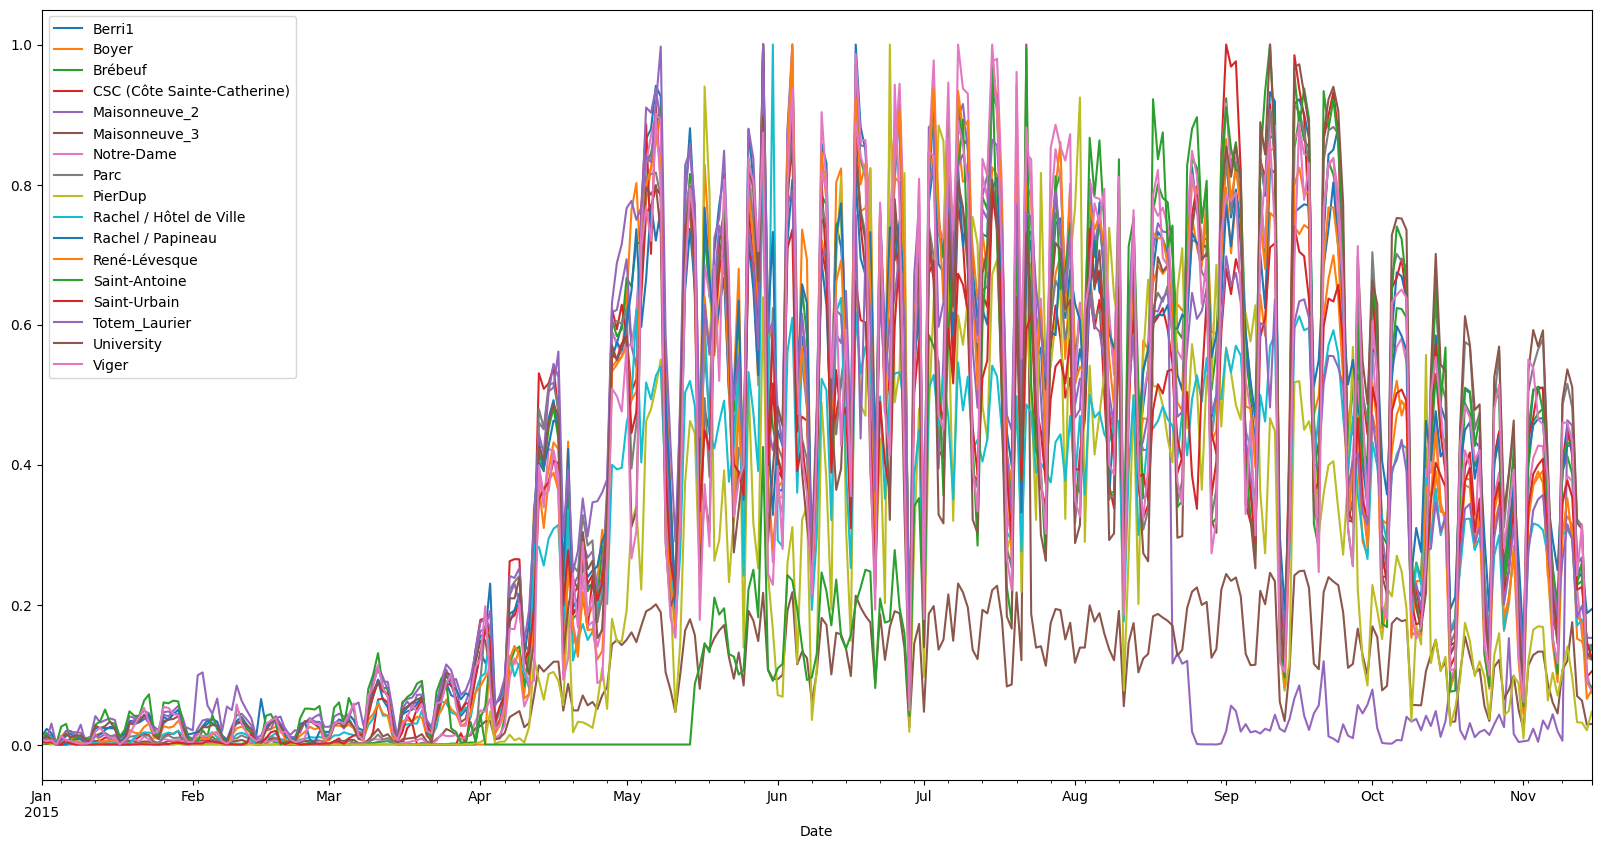

In [5]:
bike_data.loc[:, [col not in  ["Time"] for col in bike_data.columns]].plot(x="Date", figsize=(20,10))

In [6]:
# create dictionary with column names and index order starting from 0 excluding Date and Time
# this is because we want to predict the number of bikes in the future
# and we don't want to include the future in our features
node_encoder = {}
for i, col in enumerate(bike_data.columns):
    if col != 'Date' and col != 'Time':
        node_encoder[col] = i - 2
node_encoder

{'Berri1': 0,
 'Boyer': 1,
 'Brébeuf': 2,
 'CSC (Côte Sainte-Catherine)': 3,
 'Maisonneuve_2': 4,
 'Maisonneuve_3': 5,
 'Notre-Dame': 6,
 'Parc': 7,
 'PierDup': 8,
 'Rachel / Hôtel de Ville': 9,
 'Rachel / Papineau': 10,
 'René-Lévesque': 11,
 'Saint-Antoine': 12,
 'Saint-Urbain': 13,
 'Totem_Laurier': 14,
 'University': 15,
 'Viger': 16}

In [7]:
# open the BikeLanesConnections.txt and extract the connections between the nodes via links in the PyG format.
# Use the previous function of node enconder to transforms bike lanes name to the desired encoded format.
# Path: BikeLanesConnections.txt, format X <-> Y
# X and Y are the names of the bike lanes
# X <-> Y means that X and Y are connected
def get_edge_connections():
    with open('BikeLanesConnections.txt') as f:
        content = f.readlines()
    content = [x.strip() for x in content]
    content = [x.split(' <-> ') for x in content]
    content = [[node_encoder[x[0]], node_encoder[x[1]]] for x in content]
    content = torch.tensor(content).t().contiguous()
    return content

# create function to get edge and node index
def get_node_and_edge_index(bike_data):
    node_index = list(
        range(0, len(
                    [col for col in bike_data.columns if col not in ["Date", "Time"]]
                )
        )
    )
    
    
    edge_index = get_edge_connections()

    return node_index, edge_index


# create function to create a Data object in Pytorch Geometric for each row
def get_all_nodes_features_and_labels(dataframe, k = 12):
    """
    Each feature vector from the nodes is the vector of lagged values of the
    bike count from previous k Date. It assumes the dataframe is ordered by Date and Time.
    """
    all_nodes_features = []
    all_nodes_labels = []
    for j in [col for col in dataframe.columns if col not in ["Date", "Time"]]:
        node_features_across_dates = []
        node_labels_across_dates = []
        for i in range(dataframe.shape[0]):
            # get the previous k values
            lagged_values = dataframe[j].iloc[i-k:i].values
            lagged_values = torch.tensor(lagged_values).float()
            label_value = torch.tensor(dataframe[j].iloc[i]).float()
            # if there are not k previous values, skip the row
            if len(lagged_values) == k:
                node_features_across_dates.append(lagged_values)
                node_labels_across_dates.append(label_value)
        all_nodes_features.append(node_features_across_dates)
        all_nodes_labels.append(node_labels_across_dates)

    return all_nodes_features, all_nodes_labels

# showcasing one graph
node_index, edge_index = get_node_and_edge_index(bike_data)
all_nodes_features, all_nodes_labels = get_all_nodes_features_and_labels(bike_data, k=7)
print(all_nodes_features[0][0], all_nodes_labels[0][0])

tensor([0.0065, 0.0088, 0.0094, 0.0000, 0.0043, 0.0123, 0.0150]) tensor(0.0081)


In [8]:
graph_list = []
for date_index in range(len(all_nodes_features[0])):
    node_features = [all_nodes_features[i][date_index] for i in range(len(all_nodes_features))]
    node_labels = [all_nodes_labels[i][date_index] for i in range(len(all_nodes_labels))]
    graph = Data(x=torch.stack(node_features), y=torch.stack(node_labels), edge_index=edge_index)
    graph_list.append(graph)
print(len(graph_list))
graph = graph_list[0]
graph

312


Data(x=[17, 7], edge_index=[2, 27], y=[17])

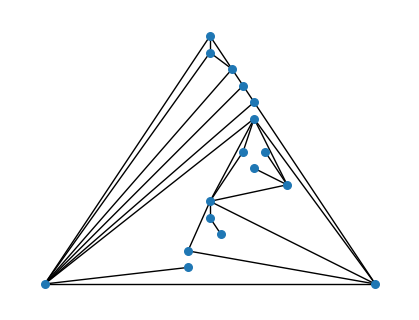

In [9]:
def convert_to_networkx(graph, n_sample=None):
    g = to_networkx(graph, node_attrs=["x"])
    y = graph.x.numpy()

    if n_sample is not None:
        sampled_nodes = random.sample(g.nodes, n_sample)
        g = g.subgraph(sampled_nodes)

    return g


def plot_graph(g):
    plt.figure(figsize=(4, 3))
    nx.draw_planar(g, node_size=30, arrows=False, node_color=None)
    plt.show() 
    
    
g = convert_to_networkx(graph, n_sample=None)
plot_graph(g)

In [10]:
class RandomNodeSplitter:
    def __init__(self, train_val_test_ratio = [0.8, 0.1, 0.1]):
        self.train_val_test_ratio = train_val_test_ratio
        self.has_mask = False
    

    def setup_split(self, num_nodes) -> None:
        train_mask = torch.zeros(num_nodes, dtype=torch.bool)
        val_mask = torch.zeros(num_nodes, dtype=torch.bool)
        test_mask = torch.zeros(num_nodes, dtype=torch.bool)

        # randomly assign nodes to train, val, test with permutation
        train_ratio = self.train_val_test_ratio[0]
        train_n = int(num_nodes * train_ratio)
        val_ratio = self.train_val_test_ratio[1]
        val_n = int(num_nodes * val_ratio)

        permutation = torch.randperm(num_nodes)
        train_mask[permutation[:train_n]] = 1
        val_mask[permutation[train_n:train_n+val_n]] = 1
        test_mask[permutation[train_n+val_n:]] = 1

        self.train_mask = train_mask
        self.val_mask = val_mask
        self.test_mask = test_mask

        self.has_mask = True


    def __call__(self, graph, save_mask=True) -> pyG.data.data.Data:
        if self.has_mask is False or save_mask is False:
            print("Generating new random split.")
            self.setup_split(graph.num_nodes)

        # assign masks to graph
        graph.train_mask = self.train_mask
        graph.val_mask = self.val_mask
        graph.test_mask = self.test_mask

        return graph

split = RandomNodeSplitter()
graph = split(graph)
graph

Generating new random split.


Data(x=[17, 7], edge_index=[2, 27], y=[17], train_mask=[17], val_mask=[17], test_mask=[17])

In [11]:
# using loader to get the full dataset but split into train, val, test
split = RandomNodeSplitter()
split.setup_split(graph.num_nodes)
graph_list = [split(graph) for graph in graph_list]
loader = DataLoader(graph_list, batch_size=len(graph_list), shuffle=False)
for dataset in loader:
    break
dataset

DataBatch(x=[5304, 7], edge_index=[2, 8424], y=[5304], train_mask=[5304], val_mask=[5304], test_mask=[5304], batch=[5304], ptr=[313])

# Graph Convolutional Network (GCN)

In [13]:
def eval_node_regression(model, graph, mask):
    model.eval()
    pred = model(graph)
    return F.mse_loss(pred[mask], graph.y[mask])

def train_node_regression(model, graph, optimizer, criterion, n_epochs=200):
    pbar = tqdm(range(1, n_epochs + 1))
    for epoch in pbar:
        model.train()
        optimizer.zero_grad()
        out = model(graph)
        loss = criterion(out[graph.train_mask], graph.y[graph.train_mask])
        loss.backward()
        optimizer.step()

        reg_loss = eval_node_regression(model, graph, graph.val_mask)

        # use pbar to print loss every 1% of the training
        if epoch % (n_epochs // 100) == 0:
            pbar.set_description(f"Loss train: {loss.item():.4f}. Validation loss: {reg_loss:.4f}")

    return model


class GCN(torch.nn.Module):
    def __init__(self, num_node_features:int, dim_last_layer:int):
        super().__init__()
        self.gnn_seq = pyG.nn.Sequential(
            "x, edge_index",
            [
                (GCNConv(num_node_features, 32), 'x, edge_index -> x'),
                nn.ReLU(inplace=True),
                (GCNConv(32, 16), 'x, edge_index -> x'),
                nn.ReLU(inplace=True),
            ]
        )
        self.classifier_seq = nn.Sequential(
            nn.Linear(16, dim_last_layer)
        )

    def forward(self, graph):
        x, edge_index = graph.x, graph.edge_index
        h = self.gnn_seq(x, edge_index)
        out = self.classifier_seq(h)
        return out.flatten()
    
device = "cpu"
graph = dataset
gcn = GCN(graph.num_features, 1)
optimizer_gcn = torch.optim.Adam(gcn.parameters(), lr=1e-4)
criterion = nn.MSELoss()
gcn = train_node_regression(gcn, graph, optimizer_gcn, criterion, n_epochs=int(1e+4))
test_loss = eval_node_regression(gcn, graph, graph.test_mask)
print(f'Test loss: {test_loss:.3f}')

Loss train: 0.0201. Validation loss: 0.0192: 100%|██████████| 10000/10000 [03:24<00:00, 48.95it/s]

Test loss: 0.017
